# Recommendation systems for online shop fashion recommendations 
Using the H&M dataset to develop different strategies for recommendation systems for different business contexts. 

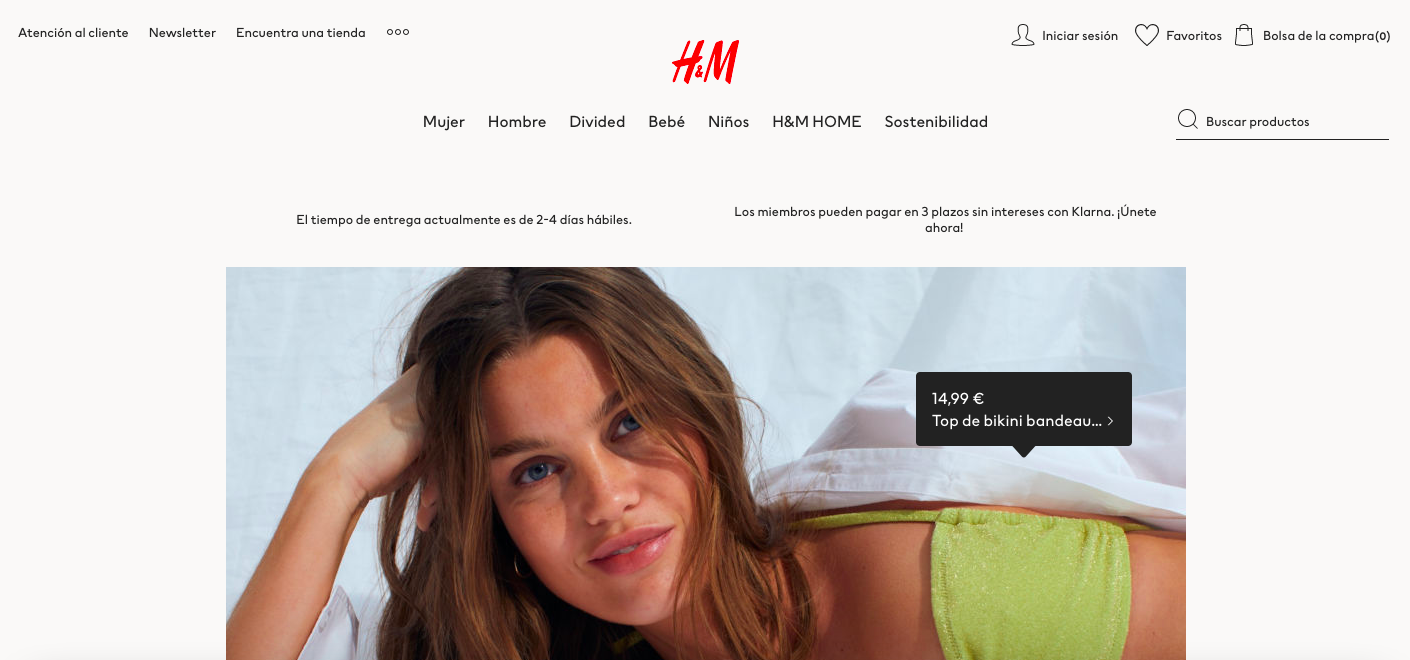

### Outline: 
1. Exploratory data analysis and visualisation – getting to know the data
2. Popularity-based recommendation system for new customers 
3. NLP-based recommender system that suggests similar articles to the one that is currently in the shopping basked (before purchasing)
4. Deep learning collaborative filtering for product recommendations after purchase ("other customers who bought this also liked...")

## Part 1: Exploratory data analysis and visualisation 

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math
import numpy as np
import seaborn as sns
import os.path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Dropout
from keras.models import Model
import plotly.express as px

%matplotlib inline  

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load data
articles = pd.read_csv('../input/handm-dataset-128x128/articles.csv')
articles.head(3)

In [ ]:
articles.columns

This table contains all H&M articles with details such as a type of product, a color, a product group and other features.

### Article data description:

- article_id: A unique identifier of every article.

- product_code, prod_name: A unique identifier of every product and its name (not the same).

- product_type, product_type_name, product_group_name: The group of product_code and its name

- graphical_appearance_no, graphical_appearance_name: The group of graphics and its name

- colour_group_code, colour_group_name: The group of color and its name

- perceived_colour_value_id, perceived_colour_value_name, perceived_colour_master_id, perceived_colour_master_name: The added color info

- department_no, department_name: A unique identifier of every dep and its name

- index_code, index_name: A unique identifier of every index and its name

- index_group_no, index_group_name: A group of indeces and its name

- section_no, section_name: A unique identifier of every section and its name

- garment_group_no, garment_group_name: A unique identifier of every garment and its name

- detail_desc: Details

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='index_name', color='orange')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

**Graph 1** In the histogram we can see the comparison of different categories. Ladieswear accounts for a significant part of all dresses (over 25000). Sportswear has the smallest portion.

In [ ]:
fig = px.sunburst(articles, path=['index_group_name', 'index_name'],width=800,
    height=800,color_discrete_sequence=px.colors.cyclical.Edge)
fig.show()

**Graph 2** Now, we can observe further division into index group-index structure. Ladieswear and Children/Baby have subgroups.

In [ ]:
fig = px.sunburst(articles, path=['product_group_name', 'product_type_name'],width=800,
    height=800,color_discrete_sequence=px.colors.cyclical.Edge)
fig.show()

**Graph 3** Now look at the product group-product structure. Sub-category trousers prevails, followed by dress, sweater & T-shirt category. E.g. accessories are really various, among the most numerious: bags, earrings and hats. 

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

**Graph 4** The garments grouped by index: **Jersey fancy** is the most frequent garment, especially for women and children. The next by number is accesories, many various accessories with low price. Some garments don't have representation for all groups.

In [ ]:
customers = pd.read_csv('../input/handm-dataset-128x128/customers.csv')
customers.head(3)

In [ ]:
customers = customers.replace("NONE", "None") # Since sometimes it's spelled "NONE" and sometimes "none", I will make them all equal

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
plt.title('Distribution of members and non-members') 
ax = sns.histplot(data=customers, y='club_member_status', color='green')
ax.set_xlabel('count by member status')
ax.set_ylabel('membership status')
plt.show()

**Graph 5** Histogram with distribution into club-members (active), pre-create and left (ex-members)

In [ ]:

plt.figure(figsize=(10,5))
plt.title('Age distribution of customers') 
plt.xlim(0,100)
plt.xlabel('Number of customers')
plt.ylabel('Age')
sns.distplot(customers['age'],bins=10,kde=False)
plt.show()



**Graph 6** The most represented 2 age categories are from 18 till early 30's, then customers drop significantly

In [ ]:
f, ax = plt.subplots(figsize=(15, 7))
plt.title('Fashion news frequency') 
ax = sns.histplot(data=customers, y='fashion_news_frequency', color='green')
ax.set_xlabel('number of customers')
plt.show()

**Graph 7** In the following histogram, we can compare customers regularly interested in fashion news vs. not interested (prevailing).

### Visualising all the articles using a sliding button 
Here you can explore the images linked to the data set sliding the button in either direction.

In [ ]:
# Import all faces as a flattened array
from skimage import io
ic = io.ImageCollection('../input/handm-dataset-128x128/images_128_128/*/*.jpg') 
print("finished loading")

In [ ]:
ic = np.array(ic)
ic_flat = ic.reshape((len(ic), -1))
print("finished running")

In [ ]:
ic.shape 

In [ ]:
# Shape of array
number, m, n, weird = ic.shape  

In [ ]:
import ipywidgets as widgets
from ipywidgets import interact

def view_image(n=0):
    plt.imshow(ic[n], cmap='gray', interpolation='nearest')
    plt.show()

w = interact(view_image, n=(0, len(ic)-1))


Importing ipywidgets library enables interactive visualization of the images from the database. However, the loading for 100k + takes time.

# Part 2: Simple popularity-based recommender for new customers
In this part, we want to simply rank the products by how often they have been purchased overall, so we can make some initial recommendations for customers about whom we have no information at all. 

In [ ]:
transactions = pd.read_csv('../input/handm-dataset-128x128/transactions_train.csv')
transactions = transactions.dropna()
print("finished loading")

In [ ]:
# take a smaller set of data to speed things up
transactions = transactions.head(1000)

In [ ]:
# Count how often the different articles were bought
popular_products = transactions['article_id'].value_counts()

In [ ]:
# See the 10 most frequently bought products
popular_products.head(10)

In [ ]:
# Plot the most frequently bought products as bar plot
popular_products.head(30).plot(kind = "bar")

In [ ]:
popular_items = popular_products.head(10).index

In [ ]:
k=len(popular_items)
fig = plt.figure(figsize=(30, 5))

plt.title('Most popular items in the store (some images are missing)',size=30)
plt.axis('off')

for item, i in zip(popular_items, range(1, k+1)):
    try:
        article_id = str(item)
        path = "../input/handm-dataset-128x128/images_128_128/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
        image = plt.imread(path)
        fig.add_subplot(1, k, i)    
        plt.title('Article %i'%item,size=15)
        plt.axis('off') 
        plt.imshow(image)
    except: 
        pass
        

# Part 3: Content-based recommender 
## Recommender system based on detailed descriptions of articles

This notebook contains a recommender system that recommends similar articles based on their product descriptions. To achieve this, it computes pairwise cosine similarity scores for all articles based on their detailed descriptions and recommends articles based on that similarity score threshold.

Source: https://www.datacamp.com/tutorial/recommender-systems-python

In [ ]:
articles = articles.head(1500) # Take only 1000 articles because otherwise the system crashes

In [ ]:
# I realised that some images are missing, so I am removing those items with missing images from the data set
articles["image_exists"] = 0 # I realised not all articles have images, so I will delete those. For this I made a new column that stores the variable "picture exists"

for iRow in range(len(articles['article_id'])): 
    article_id = str(articles.iloc[iRow, 0])
    path = "../input/handm-dataset-128x128/images_128_128/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    if os.path.isfile(path) == True: 
        articles.iloc[iRow, 25] = 1
articles.head()

In [ ]:
# Drop rows with missing images and then drop the variable, which has served its purpose
articles = articles.loc[articles['image_exists'] == 1] # drop columns where images are missing
articles = articles.drop('image_exists', 1)

In [ ]:
articles.shape # we have a bit less data now but not too much was lost

In [ ]:
# We will work here with the detailed descriptions available of articles
articles['detail_desc'].head()

We are facing a Natural Language Processing problem. We want to extract features from the text data in order to compute the similarity between them. We want to have the text descriptions as vectors. 

Word vectors are vectorized representations of words in a document. The vectors have semantic values. For example, "t-shirt" and "shirt" should have vector representations close to each other, while "pants" and "necklace" should be far from each other. 

We will compute Term Frequency-Inverse Document Frequency (TF-IDF) vectors for each text. This gives us a matrix where each column represents a word in the overview vocabulary (all the words that appear in at least one document), and each column represents an article in the dataset.

In its essence, the TF-IDF score is the frequency of a word occurring in a document, down-weighted by the number of documents in which it occurs. This is done to reduce the importance of words that frequently occur in plot overviews and, therefore, their significance in computing the final similarity score.

Scikit-learn has a built-in TfIdfVectorizer class which is what we will be using here.


In [ ]:
#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
articles['detail_desc'] = articles['detail_desc'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(articles['detail_desc'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

In [ ]:
#Array mapping from feature integer indices to feature name.
tfidf.get_feature_names()[100:110]

Different similarity measures could be used for this task, but we will use the cosine similarity between two articles. It is independent magnitude and easy and fast to calculate. 

Since we have used the TF-IDF vectorizer, calculating the dot product between each vector will directly give us the cosine similarity score. Therefore, we will use sklearn's linear_kernel() instead of cosine_similarities() since it is faster.

This would return a matrix of shape 1000x1000 (or however many articles you have in the dataset), which means each movie overview cosine similarity score with every other movie overview. Hence, each movie will be a 1x45466 column vector where each column will be a similarity score with each movie.

In [ ]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
cosine_sim.shape

In [ ]:
cosine_sim[1]

We're going to define a function that takes in an article ID as an input and outputs a list of the 10 most similar articles. Firstly, for this, we need a reverse mapping of article IDs and data frame indices. In other words, we need a mechanism to **identify the index** of an article in our articles data frame, **given its article ID**.

In [ ]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(articles.index, index=articles['article_id']).drop_duplicates()

In [ ]:
indices[:10]

The next step is to define a recommendation function. It will: 

* Get the index of an article given it's article ID
* Get the list of cosine similarity scores for that particular article with all articles 
* Convert it into a list of tuples where the first element is its position, and the second is the similarity score
* Sort the aforementioned list of tuples based on the similarity scores; that is, the second element
* Get the top 10 elements of this list, ignoring the first element as it refers to self (the article most similar to a particular article is the article itself) ACTUALLY I am getting item 10 to 20 from the list, because the top articles are too similar... 
* Return the articles corresponding to the indices of the top elements


In [ ]:
# Function that takes in an article ID as input and outputs most similar articles
def get_recommendations(article_id, cosine_sim=cosine_sim):
    # Get the index of the article that matches the ID
    idx = indices[article_id]

    # Get the pairwsie similarity scores of all articles with that article
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar articles
    sim_scores = sim_scores[11:21]

    # Get the articles indices
    article_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar articles
    return articles['article_id'].iloc[article_indices]

In [ ]:
get_recommendations(110065001)

In [ ]:
indices[:10]

In [ ]:
BASE = '../input/handm-dataset-128x128/images_128_128/' 
item = 108775015 # Test a random item
name1 = BASE+'0'+str(item)[:2]+'/0'+str(item)+'.jpg'
plt.figure(figsize=(20,5))
img1 = cv2.imread(name1)[:,:,::-1]
plt.title('So, the customer bought this item:',size=18)
plt.axis('off')
plt.imshow(img1)

In [ ]:
# see results here
recommendations = get_recommendations(item)
print(recommendations)

In [ ]:
name2 = BASE+'0'+str(recommendations.iloc[0])[:2]+'/0'+str(recommendations.iloc[0])+'.jpg'
name3 = BASE+'0'+str(recommendations.iloc[1])[:2]+'/0'+str(recommendations.iloc[1])+'.jpg'
name4 = BASE+'0'+str(recommendations.iloc[2])[:2]+'/0'+str(recommendations.iloc[2])+'.jpg'

plt.figure(figsize=(20,5))
img2 = cv2.imread(name2)[:,:,::-1]
img3 = cv2.imread(name3)[:,:,::-1]
img4 = cv2.imread(name4)[:,:,::-1]

plt.subplot(1,4,2)
plt.title('Recommendation 1',size=18)
plt.axis('off')
plt.imshow(img2)
plt.subplot(1,4,3)
plt.title('Recommendation 2',size=18)
plt.axis('off')
plt.imshow(img3)
plt.subplot(1,4,4)
plt.title('Recommendation 3',size=18)
plt.axis('off')
plt.imshow(img4)
plt.show()  

# Using deep learning to recommend items 
In the next step of this analysis, we used transactions between customers and products to come up with suggestions for customers. In this step, we suggest items that a customer might want to buy in the future, based on purchases of customers who have similar profiles, while in the previous step, we suggested articles that are similar to an item that is currently in the basket. 

In [ ]:
# Load transaction data frame
transactions = pd.read_csv('../input/handm-dataset-128x128/transactions_train.csv')
transactions = transactions.head(2000)
transactions.head()

In [ ]:
transactions['bought'] = 1 #the interaction matrix will be binary
df=transactions[['customer_id', 'article_id', 'bought']]
df.head()

In [ ]:
df = df.drop_duplicates()

In [ ]:
# Creating a sparse pivot table with customers in rows and items in columns
customer_items_matrix_df = df.pivot(index   = 'customer_id', 
                                    columns = 'article_id', 
                                    values  = 'bought').fillna(0)
customer_items_matrix_df.head(10)

In [ ]:
customer_items_matrix_df.shape

Once we have read the dataset, the next step is to split it into a test and train dataset. Here, 33% of the dataset is considered as a test, and the rest 67% is considered as a training dataset. Training neural network requires a large amount of data for better accuracy.

In [ ]:
customer_items_matrix_df_train, customer_items_matrix_df_test = train_test_split(customer_items_matrix_df,test_size=0.33, random_state=42)
print(customer_items_matrix_df_train.shape, customer_items_matrix_df_test.shape)

In [ ]:
# Calculate matrix sparsity

how_sparse = customer_items_matrix_df_train.values.mean()*100

print("We have only", how_sparse, "percent of the values filled in the sparse matrix.")

# Model 
The arquitecture of the used model was adapted from the original article published in 2017 by NVIDIA: https://arxiv.org/pdf/1708.01715.pdf **"Training deep autoencoders for collaborative filtering"**

The autoenconder consists of two neural networks, encoder and decoder, fused together. They are mainly a dimensionality reduction (or compression) algorithm.

The model has only one layer for Encoder and one layer for Decoder the size is 512, the latent space in middle of the model has 256 dimensions. We’re using the Keras functional API

# What is an autoencoder?

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. Additionally, in almost all contexts where the term "autoencoder" is used, the compression and decompression functions are implemented with neural networks.

1) Autoencoders are data-specific, which means that they will only be able to compress data similar to what they have been trained on. This is different from, say, the MPEG-2 Audio Layer III (MP3) compression algorithm, which only holds assumptions about "sound" in general, but not about specific types of sounds. An autoencoder trained on pictures of faces would do a rather poor job of compressing pictures of trees, because the features it would learn would be face-specific.

2) Autoencoders are lossy, which means that the decompressed outputs will be degraded compared to the original inputs (similar to MP3 or JPEG compression). This differs from lossless arithmetic compression.

3) Autoencoders are learned automatically from data examples, which is a useful property: it means that it is easy to train specialized instances of the algorithm that will perform well on a specific type of input. It doesn't require any new engineering, just appropriate training data.

To build an autoencoder, you need three things: an encoding function, a decoding function, and a distance function between the amount of information loss between the compressed representation of your data and the decompressed representation (i.e. a "loss" function). The encoder and decoder will be chosen to be parametric functions (typically neural networks), and to be differentiable with respect to the distance function, so the parameters of the encoding/decoding functions can be optimize to minimize the reconstruction loss, using Stochastic Gradient Descent. It's simple! And you don't even need to understand any of these words to start using autoencoders in practice.

From https://blog.keras.io/building-autoencoders-in-keras.html

In [ ]:
def autoEncoder(X):
    '''
    Autoencoder for Collaborative Filter Model
    '''

    # Input
    input_layer = Input(shape=(X.shape[1],), name='UserScore')
    
    # Encoder
    # -----------------------------
    enc = Dense(512, activation='selu', name='EncLayer1')(input_layer)

    # Latent Space
    # -----------------------------
    lat_space = Dense(256, activation='selu', name='LatentSpace')(enc)
    lat_space = Dropout(0.8, name='Dropout')(lat_space) # Dropout

    # Decoder
    # -----------------------------
    dec = Dense(512, activation='selu', name='DecLayer1')(lat_space)

    # Output
    output_layer = Dense(X.shape[1], activation='linear', name='UserScorePred')(dec)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)    
    
    return model

In [ ]:
# We want to map the input to itself (that is what auto-encoders do, apparently)
X = customer_items_matrix_df_train.values

In [ ]:
X.shape[1]

In [ ]:
# Build model
model = autoEncoder(X)

model.compile(optimizer = Adam(lr=0.0001), loss='mse')
    
model.summary()

**Train the model based on the data split**

In [ ]:
hist = model.fit(x=X, y=X,
                  epochs=50,# Using 50 here instead of 10 or 20 improved the performance very much!
                  batch_size=64,
                  shuffle=True,
                  validation_split=0.1)

After 50 epochs we get a 0.0063 star deviation between the predicted and actual purchases on the test set...

## Plot training and validation loss

### Good Fit Learning Curves 
* A good fit is the goal of the learning algorithm and exists between an overfit and underfit model. 
* A good fit is identified by a training and validation loss that decreases to a point of stability with a minimal gap between the two final loss values. 
* The loss of the model will almost always be lower on the training dataset than the validation dataset. This means that we should expect some gap between the train and validation loss learning curves. 
* This gap is referred to as the “generalization gap.” 
* A plot of learning curves shows a good fit if: The plot of training loss decreases to a point of stability. 
* The plot of validation loss decreases to a point of stability and has a small gap with the training loss. 
* Continued training of a good fit will likely lead to an overfit. 

Source: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

In [ ]:
def plot_hist(hist):
    # summarize history for loss
    fig, ax = plt.subplots()  # create figure & 1 axis

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])

plot_hist(hist)

# Recommender

In [ ]:
# Predict new Matrix Interactions, set score zero on articles customer haven't purchased
new_matrix = model.predict(X) * (X[0] == 0)

In [ ]:
# converting the reconstructed matrix back to a Pandas dataframe
new_customer_items_matrix_df  = pd.DataFrame(new_matrix, 
                                            columns = customer_items_matrix_df_train.columns, 
                                            index   = customer_items_matrix_df_train.index)
new_customer_items_matrix_df.head()

In [ ]:
print(new_customer_items_matrix_df.values.min(), new_customer_items_matrix_df.values.max())

In [ ]:
def recommender_for_customer(customer_id, interact_matrix, df_content, topn = 10):
    '''
    Recommender Articles for Customers
    '''
    pred_scores = interact_matrix.loc[customer_id].values

    df_scores   = pd.DataFrame({'article_id': list(customer_items_matrix_df.columns), 
                               'score': pred_scores})

    df_rec      = df_scores.set_index('article_id')\
                    .join(df_content.set_index('article_id'))\
                    .sort_values('score', ascending=False)\
                    .head(topn)[['score', 'prod_name']]
    
    return df_rec[df_rec.score > 0]

## Test the recommender

In [ ]:
articles = pd.read_csv('../input/handm-dataset-128x128/articles.csv') # Load this again, because we had removed some items in the previous step

In [ ]:
# EXAMPLE: ARTICLE previously purchased by the customer
hist_customer=recommender_for_customer(customer_id     = '02e0910945216963833093e0e56712e7362b01b7ef0cd4b375f857542b085020', 
                         interact_matrix = customer_items_matrix_df, 
                         df_content      = articles)


prev_items = hist_customer.index.values
k=len(prev_items)
fig = plt.figure(figsize=(30, 5))

plt.title('Example: The customer bought those items\n\n',size=20)
plt.axis('off')

for item, i in zip(prev_items, range(1, k+1)):
    article_id = str(item)
    path = "../input/handm-dataset-128x128/images_128_128/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)

In [ ]:
#EXAMPLE: SEE THE LIST OF ARTICLES previously purchased by the customer
hist_customer

In [ ]:
#EXAMPLE: Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec=recommender_for_customer(customer_id     = '02e0910945216963833093e0e56712e7362b01b7ef0cd4b375f857542b085020', 
                         interact_matrix = new_customer_items_matrix_df, 
                         df_content      = articles)

next_items = hist_customer_rec.index.values
k=len(next_items)
fig = plt.figure(figsize=(30, 5))

plt.title('Example: Next products to be recommended (sorted by best scored)\n\n',size=20)
plt.axis('off')

for item, i in zip(next_items, range(1, k+1)):
    try:
        article_id = str(item)
        path = "../input/handm-dataset-128x128/images_128_128/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
        image = plt.imread(path)
        fig.add_subplot(1, k, i)    
        plt.title('Article %i'%item,size=12)
        plt.axis('off') 
        plt.imshow(image)
    except: 
        pass
        

In [ ]:
#EXAMPLE: SEE THE LIST OF Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec

## Test the model on unseen data

In [ ]:
# We want to map the input to itself (that is what auto-encoders do, apparently)
X_test = customer_items_matrix_df_test.values

In [ ]:
X_test.shape # It's important that the second value is the same as in the training data... I guess it would be great if it was more flexible but I don't know how to do that 

In [ ]:
# Predict new Matrix Interactions, set score zero on articles customer haven't purchased
new_matrix_test = model.predict(X_test) * (X_test[0] == 0)

In [ ]:
# converting the reconstructed matrix back to a Pandas dataframe
new_customer_items_matrix_df_test  = pd.DataFrame(new_matrix_test, 
                                            columns = customer_items_matrix_df_test.columns, 
                                            index   = customer_items_matrix_df_test.index)
new_customer_items_matrix_df_test.head()

In [ ]:
# EXAMPLE: ARTICLE previously purchased by the customer
recommendations = recommender_for_customer(customer_id     = '01f597f5eba83f9709eceb5a70a99f3a4009a6e827bf7293afa4211030a29fa4', 
                                           interact_matrix = customer_items_matrix_df_test, 
                                           df_content      = articles)
print(recommendations)

In [ ]:
# EXAMPLE: ARTICLE previously purchased by the customer
hist_customer_test=recommender_for_customer(customer_id     = '01f597f5eba83f9709eceb5a70a99f3a4009a6e827bf7293afa4211030a29fa4', 
                         interact_matrix = customer_items_matrix_df_test, 
                         df_content      = articles)


prev_items = hist_customer_test.index.values
k=len(prev_items)
fig = plt.figure(figsize=(30, 5))

plt.title('Example: The customer bought those items\n\n',size=20)
plt.axis('off')

for item, i in zip(prev_items, range(1, k+1)):
    article_id = str(item)
    path = "../input/handm-dataset-128x128/images_128_128/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
    image = plt.imread(path)
    fig.add_subplot(1, k, i)
    plt.title('Article %i'%item,size=12)
    plt.axis('off') 
    plt.imshow(image)

In [ ]:
#EXAMPLE: SEE THE LIST OF ARTICLES previously purchased by the customer
hist_customer_test

In [ ]:
#EXAMPLE: Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec_test=recommender_for_customer(customer_id     = '01f597f5eba83f9709eceb5a70a99f3a4009a6e827bf7293afa4211030a29fa4', 
                         interact_matrix = new_customer_items_matrix_df_test, 
                         df_content      = articles)

next_items = hist_customer_rec_test.index.values
k=len(next_items)
fig = plt.figure(figsize=(30, 5))

plt.title('Example: Next products to be recommended (sorted by best scored)\n\n',size=20)
plt.axis('off')

for item, i in zip(next_items, range(1, k+1)):
    try:
        article_id = str(item)
        path = "../input/handm-dataset-128x128/images_128_128/0" + str(article_id[:2]) + "/0" +article_id + ".jpg"
        image = plt.imread(path)
        fig.add_subplot(1, k, i)    
        plt.title('Article %i'%item,size=12)
        plt.axis('off') 
        plt.imshow(image)
    except: 
        pass
        



In [ ]:
#EXAMPLE: SEE THE LIST OF Recommended Articles (SORTED BY BEST SCORED)
hist_customer_rec_test